# Stochastic Control Project
##### Jackson Cornell

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import torch

from numpy import random
from IPython.display import clear_output

We begin by defining the base simulator for the stochastic processes. This class will serve as a parent class for BMCO and MBRC for running stock trajectories. Monte Carlo is used for estimating expected values. Some general notation used throughout is as follows:

* $\tau$ is optimal stopping time
* $g(\tau, X_{\tau})$ is a measure of time and a Markov process at that time
* $X_n$ is a Markov process indexed by $n$
* $S_t^i$ is $i$th stochastic process at time $t$
* $W$ is Brownian motion
* $d$ is number of stochastic processes
* $r$ is risk-free interest rate
* $\delta_i$ is dividend yields
* $\sigma_i$ is volatility
* $c$ is coupon payment
* $T$ is maturity with respect to time
* $N$ is number of samples
* $M$ is number of Monte Carlo runs
* $K$ is strike price
* $F$ is nominal amount
* $B$ is barrier
* $T_i$ is dividend payment time

In [2]:
f_theta = lambda y : tf.math.round(y)

In [3]:
class BaseSim:
    '''
    BaseSim : parent class for stock simulators
    '''
    
    def __init__(self, r=0.05, delta=0.10, sigma=0.20,
                 cov=1.0, d=1, N=100, T=5, M=1, K=None,
                 F=None, B=None, T_i=None, c=None):
        '''
        BaseSim : simultes Brownian motion

        r     : risk-free interest rate
        delta : dividend yields
        sigma : volatility
        cov   : covaraince matrix for Brownian walk
        d     : number of stocks
        N     : number of time samples
        T     : time length (maturity)
        M     : number of Monte-Carlo simulations
        K     : strike price
        F     : nominal amount
        B     : barrier
        T_i   : dividend payment time 
        c     : coupon payment
        '''
        
        self.r = r
        self.delta = delta
        self.sigma = sigma
        self.d = d
        self.N = N
        self.T = T
        self.M = M
        self.K = K
        self.F = F
        self.B = B
        self.T_i = T_i
        self.c = c
        self.S = None
        self.g = None
        self.t = None
        
        # error handling
        if not np.isscalar(delta):
            if (delta.shape[0] != d):
                raise Exception('delta does not fit dimension d')
        if not np.isscalar(sigma):
            if (sigma.shape[0] != d):
                raise Exception('sigma does not fit dimension d')
        if not np.isscalar(cov):
            if (cov.shape[0] != d or cov.shape[1] != d):
                raise Exception('corr does not fit dimension d')
                
        # reformat data
        if np.isscalar(cov):
            self.cov = cov * np.eye(d)
        else :
            self.cov = cov
            
        
    def W_t(self, x_0):
        '''
        W_t : simultes Brownian motion

        x_0 : d-dimensional starting value

        returns : (M, d, N) tensor of Wiener processes
        '''

        # reformat data
        if np.isscalar(self.cov):
            cov = self.cov * np.eye(d)
        if np.isscalar(x_0):
            x_0 = x_0 * np.ones(d)

        # get parameters
        mu = np.zeros(self.d)
        scale = np.sqrt(self.N)

        # set initial values
        W = np.zeros((self.M, self.d, self.N))
        W[:, :, 0] = x_0

        for n in range(1, self.N):
            
            # sample from normal distribution
            Y_n = random.multivariate_normal(mu, self.cov, self.M)
            
            # Weiner process
            W[:, :, n] = W[:, :, n-1] + (Y_n / scale)

        return W
    
    
    def run(self):
        return None
    
    
    def value(self):
        return None
    
    
    def get_S(self):
        '''
        get_S : returns trajectory S

        returns : (M, d, N) tensor of S
        '''
        return self.S
    
    
    def get_g(self):
        '''
        get_g : returns value g()

        returns : (M, N) tensor of g()
        '''
        return self.g
    
    
    def get_t(self):
        '''
        get_t : returns time vector t

        returns : array of length N
        '''
        return self.t
    
    
    def E_g(self):
        '''
        E_g : estimates expected value of function g()

        returns : returns E[g()] wrt time
        '''
        return np.mean(self.g, axis=0)
    
    
    def E_S(self):
        '''
        E_S : estimates expected value of trajectories S

        returns : returns E[S] wrt time
        '''
        return np.mean(self.S, axis=0)
    
    
    def plot_sims(self, m=None, d=None, n=None):
        '''
        plot_sims : plots trajectories given tensor S=(M, D, N)

        m : index of simulation to plot (prints all if None)
        d : index of process to plot (prints all if None)
        n : tuple of time ranges to plot (prints all if None)

        returns: None
        '''

        M, D, N = self.S.shape

        # format indices
        if m == None:
            m = range(M)
        elif np.isscalar(m):
            m = [m]
        if d == None:
            d = range(D)
        elif np.isscalar(d):
            d = [d]
        if n == None:
            n = range(N)
        else:
            n = range(n[0], n[1])

        # plot trajectories
        for m_index in m:
            for d_index in d:
                plt.plot(self.t[n], np.squeeze(np.asarray(
                         self.S[m_index, d_index, n])))
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Trajectories')
        plt.show()
        
        
    def lower_bound(self, models):
        '''
        lower_bound : comutes estimate of parameterized model's lower bound

        model : parameterized model to estimate optimal stopping time tau

        returns: model's lower bound L
        '''

        # reformat simulation input for model
        S_tf = tf.convert_to_tensor(self.S, dtype=tf.float32)

        f = np.zeros((self.M, self.N+1))

        for n in range(self.N):

            # get samples at time index
            S_n = S_tf[:, :, n]

            # run model
            F_theta_n = models[n](S_n).numpy()
            f[:, n] = f_theta(np.squeeze(np.asarray(F_theta_n)))

        # get optimal stopping time tau
        g_tau = np.zeros(self.M)
        tau = np.argmax(f, axis=1).astype('int')
        
        for m in range(self.M):

            if tau[m] == 0 or tau[m] == self.N:
                g_tau[m] = self.g[m, self.N]
            else:
                g_tau[m] = self.g[m, tau[m]]

        # return average over simulations
        return np.mean(g_tau)
    
    
    def upper_bound(self, model):
        '''
        upper_bound : comutes estimate of parameterized model's upper bound

        model : parameterized model to estimate optimal stopping time tau

        returns: model's upper bound U
        '''
        return None

## Brownian motion

$X_{n+1} = X_n + \dfrac{Y_n}{\sqrt{N}}$, where $Y_N \sim \mathcal{N}(\mu, \sigma^2)$ and is i.i.d., and $X_0 = x_0$ is known.

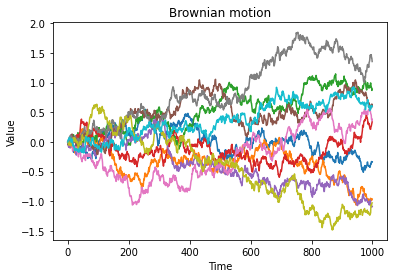

In [4]:
# parameters
d = 10
M = 1
N = 1000

# run Brownian motion simulation
brownian = BaseSim(M=M, d=d, N=N)
W = brownian.W_t(0.0)

# display results
for i in range(d):
    plt.plot(W[0, i, :])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Brownian motion')
plt.show()

## Bermudan max-call options

$S_t^i = s_0^i \exp{\left( \dfrac{r - \delta_i - \sigma_i^2}{2} t + \sigma_i W_t^i \right)}$

$g(n, x) = e^{-r t_n} \left( \underset{1 \leq i \leq d}{\text{max}} x_i - K\right)^+$

In [5]:
class BMCO(BaseSim):
    '''
    BMCO : simulator class for Bermudan max-call options
    '''
    
    def run(self, s_0):
        '''
        run : simulates d-dimensional Black-Scholes model for
              Bermudan max-call options, returns dynamics S1,...,Sd

        s_0 : d-dimensional starting value vector

        returns : trajectories and time indices
        '''

        # get parameters
        n = np.arange(self.N+1)
        self.t = n * self.T / self.N

#         # generate Brownian motion
#         W = self.W_t(0.0)

#         # generate stock trajectory
#         if np.isscalar(s_0):
#             S_det =  self.t * (self.r - self.delta - self.sigma**2) / 2
#             S_stoc =  self.sigma * W
#             self.S = s_0 * np.exp(S_det + S_stoc)
#         else :
#             t_vec = np.matrix(self.t)
#             S_det =  np.multiply(t_vec, (self.r - self.delta - self.sigma**2) / 2)
#             S_stoc =  np.multiply(self.sigma, W)
#             self.S = np.multiply(s_0, np.exp(S_det + S_stoc))

        dt=self.T/self.N
        So_vec=s_0*np.ones((1,self.M, self.d))
        
        Z=np.random.standard_normal((self.N,self.M, self.d))
        s=s_0*np.exp(np.cumsum((self.r-self.delta-0.5*self.sigma**2)*dt+self.sigma*np.sqrt(dt)*Z, axis=0))
        
        s=np.append(So_vec, s, axis=0)
        
        self.S = tf.transpose(tf.convert_to_tensor(s), perm=(1, 2, 0)).numpy()

        # return stochastic simulation of stock
        return self.S, self.t
    
    
    def value(self):
        '''
        value : calculates the value of a portfolio at each time
                step for Bermudan max-call option

        returns : (K, N) tensor of output of g()
        '''
    
        self.g = np.exp(-self.r * self.t) * np.squeeze(np.asarray(
            np.maximum(np.amax(self.S, axis=1) - self.K,
                       np.zeros((1, 1, self.t.shape[0])))))
        return self.g

## Callable multi-barrier reverse convertibles

$S_t^i = 100 \exp{\left( \dfrac{r - \sigma_i^2}{2} t + \sigma_i W_t^i \right)},\;\;\;\;\;\;\;\;\;\;\;\;$ if $t < T_i$

$\;\;\;\;\; = 100 (1 - \delta_i) \exp{\left( \dfrac{r - \sigma_i^2}{2} t + \sigma_i W_t^i \right)},\;\;$ if $t >= T_i$

$g(n, x) = \sum_{m=1}^n e^{-r t_m} c + e^{-r t_n} F,\;\;\;\;\;\;$ if $1 \leq n \leq N-1$ or $x^{d+1} = 0$

$\;\;\;\;\;\;\;\;\;\;= \sum_{m=1}^N e^{-r t_m} c + e^{-r t_N} h(x),\;\;$ if $n=N$ and $x^{d+1} = 1$

where

$h(x) = F,\;\;\;\;\;\;\;\;\;$ if $\underset{1 \leq i \leq d}{\text{min}} x_i > K$

$\;\;\;\;\;\;\; = \underset{1 \leq i \leq d}{\text{min}} x_i,\;\;$ if $\underset{1 \leq i \leq d}{\text{min}} x_i \leq K$

In [6]:
class MBRC(BaseSim):
    '''
    MBRC : simulator class for callable multi-barrier reverse convertibles
    '''
    
    def run(self):
        '''
        run : simulates d-dimensional Black-Scholes model for
              callable multi-barrier reverse convertibles, returns
              dynamics S1,...,Sd

        returns : trajectories and time indices
        '''

        # get parameters
        n = np.arange(self.N+1)
        self.t = n * self.T / self.N
        n1 = n[self.t < self.T_i]
        n2 = n[self.t >= self.T_i]
        self.S = np.zeros((self.M, self.d, self.N+1))

        # generate Brownian motion
        W = self.W_t(0.0)

        # generate stock trajectory
        if np.isscalar(self.sigma):
            S_det =  self.t * (self.r - self.sigma**2) / 2
            S_stoc =  self.sigma * W
            self.S[:, :, n2] = 100 * (1 - delta) * np.exp(S_det + S_stoc)[:, :, n2]
        else :
            t_vec = np.matrix(self.t)
            S_det =  np.multiply(t_vec, (self.r - self.sigma**2) / 2)
            S_stoc =  np.multiply(self.sigma, W)
            self.S[:, :, n2] = 100 * np.multiply(1 - self.delta,
                                                 np.exp(S_det + S_stoc)[:, :, n2])
        self.S[:, :, n1] = 100 * np.exp(S_det + S_stoc)[:, :, n1]

        # return stochastic simulation of stock
        return self.S, self.t
    
    
    def value(self):
        '''
        value : calculates the value of a portfolio at each time
                step for callable multi-barrier reverse convertibles

        returns : (K, N) tensor of output of g()
        '''
        
        # find where process breaches barrier
        index = np.argmax(self.S < self.B, axis=2)
        index = np.argmax(index < self.B, axis=1)
        t_b = self.t[index]
        t_thresh = np.matrix([self.t for _ in range(self.M)])
        for m in range(self.M):
            t_thresh[m, t_thresh < t_b[m]] = 0
            t_thresh[m, t_thresh > 0] = 1
        
        # augment process S
        X_aug = np.zeros((self.M, self.d+1, self.N))
        X_aug[:, :self.d, :] = self.S
        #X_aug[:, self.d, :] = 
    
        self.g = np.zeros((self.M, self.N))
        for m in range(N+1):
            
            if (m == self.N) or ():
                s_min = np.amin(X_aug[:, :, m], axis=1)
                cum_sum = np.zeros(self.M)
                cum_sum[s_min > self.K] = self.F * np.exp(-self.r * t[m])
                cum_sum[s_min <= self.K] = s_min[s_min <= self.K] * np.exp(-self.r * t[m])
            else:
                cum_sum = self.F * np.exp(-self.r * t[m])

            for n_index in range(m):
                cum_sum += self.c * np.exp(-self.r * t[m])
            self.g[:, m] = cum_sum
            
        return self.g

## Utility functions

In [7]:
def supremum(x, t):
    '''
    supremum : calculates supremum (or maximum) of function
    
    x : vector representing function
    t : time indices
    
    returns : time index of supremum and its value at that time
    '''
    
    n = np.argmax(x)
    return t[n], x[n]

## Simulations

Tau: 4.096


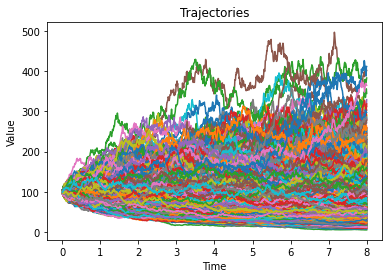

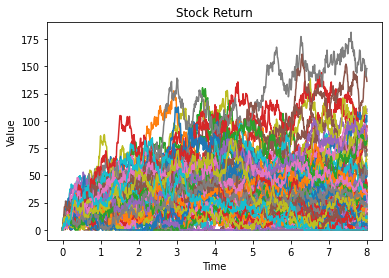

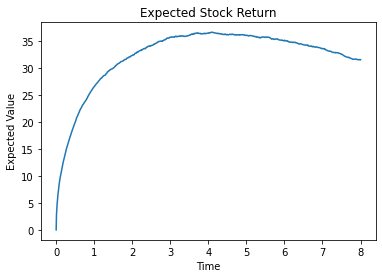

In [33]:
s_0 = 100
r = 0.05
delta = 0.1
sigma = 0.2
cov = 1
d = 10
T = 8
N = 1000
M = 5000
K = 100

BMCO_sim = BMCO(r, delta, sigma, cov, d, N, T, M, K=K)
S, t = BMCO_sim.run(s_0)
g = BMCO_sim.value()
exp_g = BMCO_sim.E_g()

tau, g_tau = supremum(exp_g, t)

print('Tau:', tau)

BMCO_sim.plot_sims(d=0)

for m in range(100):
    plt.plot(t, g[m, :])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stock Return')
plt.show()

plt.plot(t, exp_g)
plt.xlabel('Time')
plt.ylabel('Expected Value')
plt.title('Expected Stock Return')
plt.show()

In [26]:
# F = 100
# K = 100
# B = 60
# T = 10
# N = 100
# M = 10000
# T_i = 5
# c = 7 /12
# delta = 0.05
# d = 2
# r = 0
# sigma = 0.2
# cov = np.matrix([[1, 0.1],
#                  [0.1, 1]])

# MBRC_sim = MBRC(r, delta, sigma, cov, d, N, T, M, K=K, F=F, B=B, T_i=T_i, c=c)
# S, t = MBRC_sim.run(s_0)
# g = MBRC_sim.value()
# exp_g = MBRC_sim.E_g()

# MBRC_sim.plot_sims(m=0)

# plt.plot(t, exp_g)
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Stock')
# plt.show()

## Neural Network Approximation

### Setup

$V_n = \underset{\tau \in \mathcal{T}_n}{\sup} \mathbb{E} \left[ g(\tau, X_{\tau}) \right]$

for $n=0, 1, ..., N$ where $\mathcal{T}_n$ is the set of all $X$-stopping times in $n \leq \tau \leq N$. Let $f_n, f_{n+1}, ... f_N : \mathbb{R}^d \rightarrow \{ 0, 1 \}$ be a function of $X_n$ that is $1$ when $n = \tau$ and $0$ otherwise, with $f_N \equiv 1$. Then,

$\tau_{n+1} = \sum_{m=n+1}^N m f_m(X_m) \prod_{j=n+1}^{m-1} (1 - f_j(X_j))$

$\tau^{\theta} = \sum_{n=1}^N n f^{\theta_n}(X_n) \prod_{j=n}^{n-1} (1 - f^{\theta_j}(X_j))$


### Architecture

The model architecture is fairly straightforward. The input is the $d$-dimensional value of a stock $S$ at time $t$. The model has a minimum of 2 hidden layers, with each hidden layer using the ReLU activation function. The authors suggest using a unit size of about $d + 40$, but this portion of the paper could benefit the most out of experimentation. The output is a single neuron with a sigmoid activation function, which approximates the decision function of $f(X_n) = 1$ when $n = \tau$ and $0$ otherwise.

### Training

Let $(x_n^k)_{n=0}^N$ be $k=1,2,...$ independent realizations of a path through Monte Carlo simulation. Define $f_N \equiv 1$ and recursively determine $\theta_n$ for $n \leq N-1$.

In [27]:
def construct_NN(inputs, d, units, hidden_layers=2):
    '''
    construct_NN : creates architecture for deep neural net
                   model

    x             : input layers
    units         : number of units per hidden layer (can be
                    scalar or array corresponding to number of
                    hidden layers)
    hidden_layers : number of hidden layers

    returns: output layer
    '''
    
    x = inputs
    
    # use functional API to iterate through hidden layers
    prev_units = d
    for h in range(hidden_layers):
        
        # check if 'units' is scalar or array
        if np.isscalar(units):
            initializer = keras.initializers.RandomUniform(minval=-tf.math.sqrt(6.0 / (prev_units + units)),
                                                           maxval=tf.math.sqrt(6.0 / (prev_units + units)))
            x = keras.layers.Dense(units,
                                   activation='relu',
                                    kernel_initializer=keras.initializers.Zeros(),   #=initializer,
                                    bias_initializer=keras.initializers.Zeros(),
                                   name='hidden_layer_'+str(h+1))(x)
            prev_units = units
        else:
            initializer = keras.initializers.RandomUniform(minval=-tf.math.sqrt(6.0 / (prev_units + units[h])),
                                                           maxval=tf.math.sqrt(6.0 / (prev_units + units[h])))
            x = keras.layers.Dense(units[h],
                                   activation='relu',
                                   kernel_initializer=keras.initializers.Zeros(),   #=initializer,
                                    bias_initializer=keras.initializers.Zeros(),
                                   name='hidden_layer_'+str(h+1))(x)
            prev_units = units[h]
            
    output = keras.layers.Dense(1, activation='sigmoid', name='output')(x)
            
    # return model
    return output


def tau_n_plus_1(y_pred, n, N, K):
    '''
    get_tau : estimate tau over simulations and time indices

    X      : tensor of input trajectories
    y_pred : estimated values for f(X)

    returns: (K, N) tensor
    '''
    
    # map outputs in (0,1) -> {0,1}
    #f = f_theta(y_pred)
    f = y_pred
    
    # to optmize runtime
    minus_f = 1 - f
    
    # initialize tau
    tau = tf.Variable(tf.zeros(K))
    
    # iterate over time indices N
    for m in range(n, N):
        
        cum_prod = tf.Variable(tf.ones(K))

        for j in range(0, m):
            cum_prod.assign(cum_prod * minus_f[:, j])
            
        if (m == N-1):
            tau.assign(tau + m * cum_prod)
        else :
            tau.assign(tau + m * f[:, m] * cum_prod)
            
    return tau


def reward(g, y_pred, n, N, K):
    '''
    reward : calculate reward given model estimate

    X      : tensor of input trajectories
    g      : tensor of values g(X)
    y_pred : estimated values for f(X)

    returns: output layer
    '''
    
    # get tau
    tau = tau_theta(y_pred, n, N, K)
    tau_int = tau.numpy().astype('int')

    g_tau = tf.convert_to_tensor([g[k, tau_int[k]] for k in range(K)],
                                 dtype=tf.float32)
    
    r = g[:, n] * y_pred[:, n] + g_tau * (1 - y_pred[:, n])
     
    # average over simulations
    return tf.math.reduce_mean(r, axis=1)


def loss_function(g, y_pred, tau, n, K):
    
    # get tau of n+1 and change type
    tau_int = tau[:, n+1].numpy().astype('int')
    
    # get g(tau of n+1)
    g_tau = tf.convert_to_tensor([g[k, tau_int[k]] for k in range(K)],
                                 dtype=tf.float32)
    
    # calculate reward function
    r = g[:, n] * tf.transpose(y_pred) + g_tau * (1 - tf.transpose(y_pred))
    
    # return expected value
    return tf.math.reduce_mean(-r)


def training(X, g, epochs, units, hidden_layers, lr):
    
    models = []
    rewards = []
    
    # convert data type
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    g = tf.convert_to_tensor(g, dtype=tf.float32)
    
    # paramters
    K, D, N_plus_1 = X.shape
    N = N_plus_1 - 1
    
    # variables
    tau = np.zeros((K, N_plus_1))
    f = np.zeros((K, N_plus_1))
    tau[:, N] = N * np.ones(K)
    f[:, N] = np.ones(K)
    tau = tf.Variable(tf.convert_to_tensor(tau, dtype=tf.int64),
                      dtype=tf.int64)
    f = tf.Variable(tf.convert_to_tensor(f, dtype=tf.float32),
                    dtype=tf.float32)
        
    for n in range(N-1, -1, -1):
        
        if (n == 0):
            # never stop
            model = lambda x : tf.zeros(len(x))
            tau[:, n].assign(tau[:, n+1])
            f[:, n].assign(np.zeros(K))
            
        else:
            # build model
            inputs =  keras.Input(shape=(D,), name='input')
            outputs = construct_NN(inputs, D, units, hidden_layers)
            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = keras.Model(inputs, outputs, name='optimal_stopper_n'+str(n))
            
            # get current samples
            X_n = X[:, :, n]

            reward_epoch = []
            for i in range(epochs):

                with tf.GradientTape() as tape:

                    # get model output
                    y_pred = model(X_n)

                    # calculate loss as negative reward
                    loss = loss_function(g, y_pred, tau, n, K)

                # update parameters
                gradients = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, model.trainable_weights))

                # display progress
                clear_output(wait=True)
                print("n =", n, "Epoch", i+1, "reward:", -loss.numpy())

                reward_epoch.append(-loss.numpy())

            # update variables
            f[:, n].assign(tf.reshape(f_theta(y_pred), K))
            tau[:, n].assign(tf.math.argmax(f, axis=1))
        
        rewards.append(reward_epoch)
        models.append(model)
        
    return models[::-1], rewards[::-1]

In [28]:
# paramters
units = d + 40
hidden_layers = 2
epochs = 40  #[0, 50, 50, 50, 40, 40, 30, 20, 10]
lr = 1e-1

# train model
models, rewards = training(S, g, epochs, units, hidden_layers, lr)

n = 1 Epoch 40 reward: 35.14228


In [29]:
# show models on test data
for n in range(N):
    print("n =", n, ":\n")
    print(models[n](S[:20, :, n]).numpy())
    print('')

n = 0 :

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

n = 1 :

[[0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]]

n = 2 :

[[0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]
 [0.03945077]]

n = 3 :

[[0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]
 [0.03945079]]

n = 4 :

[[0.0394508]
 [0.0394508]
 [0.0394508]
 [0.039

Text(0.5, 1.0, 'Reward')

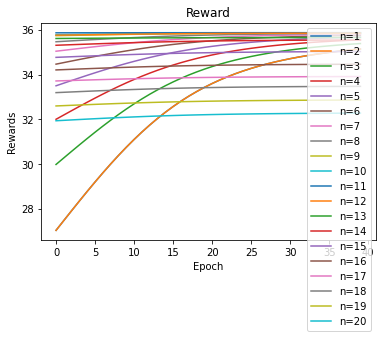

In [30]:
# display rewards vs epoch
for i, reward in enumerate(rewards):
    plt.plot(reward, label="n={}".format(i+1))
plt.xlabel('Epoch')
plt.ylabel('Rewards')
plt.legend()
plt.title('Reward')

In [31]:
# test on new sim
BMCO_test = BMCO(r, delta, sigma, cov, d, N, T, 5000, K=K)
_, _ = BMCO_test.run(s_0)
_ = BMCO_test.value()

L_hat = BMCO_test.lower_bound(models)
print("Lower bounds:", L_hat)

Lower bounds: 36.2987314494256
